In [ ]:
!pip install GPyOpt --quiet
!pip install GPy --quiet

In [2]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
import random

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

In [3]:
#dataset = UCI Car Evaluation
names=['buying','maint','doors','persons','lug_boot','safety','class']
df = pd.read_csv('car.data', names = names)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

In [5]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [6]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [8]:
#KNN Classification

#search domain
bounds = [ {'name': 'leaf_size', 'type': 'continuous', 'domain': (1, 100)},
        {'name': 'n_neighbors', 'type': 'discrete', 'domain': (3,4,5,6,7)}
      ]


def knn_score(parameters):
  params = {
        'leaf_size': int(parameters[0][0]),
        'n_neighbors':int(parameters[0][1])
    }
  
  clf = KNeighborsClassifier(leaf_size=params['leaf_size'],n_neighbors=params['n_neighbors'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,5)

  return score

In [10]:
kernel1 = GPy.kern.StdPeriodic(input_dim=1,lengthscale=1.782,active_dims=[0],period=13) \
          * GPy.kern.Matern52(input_dim=1,lengthscale=0.506,active_dims=[0])
kernel2 = GPy.kern.StdPeriodic(input_dim=1,lengthscale=1.579,active_dims=[1],period=2)
kernel = kernel1 + kernel2

optimizer = GPyOpt.methods.BayesianOptimization(f=knn_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
optimizer.run_optimization(max_iter=20)

X=(optimizer.X)
m, v = optimizer.model.predict(X)
log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))

print(log_mll)

[[64.75169262]]


In [12]:
a=0
a_list=[]
mll_list=[]
for i in range (40):
  a=a+0.1
  a_list.append(a)

  kernel1 = GPy.kern.StdPeriodic(input_dim=1,variance=a,lengthscale=1.782,active_dims=[0],period=13) \
          * GPy.kern.Matern52(input_dim=1,lengthscale=0.506,active_dims=[0])
  kernel2 = GPy.kern.StdPeriodic(input_dim=1,lengthscale=1.579,active_dims=[1],period=2)
  kernel = kernel1 + kernel2


  optimizer = GPyOpt.methods.BayesianOptimization(f=knn_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
  optimizer.run_optimization(max_iter=20)
  X=(optimizer.X)
  m, v = optimizer.model.predict(X)
  mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
  mll_list.append(mll)
  print(f"log mll {mll}")

log mll [[0.53767223]]
log mll [[19.27340523]]
log mll [[10.80805758]]
log mll [[70.37472963]]
log mll [[30.17382054]]
log mll [[51.83980792]]
log mll [[37.26620736]]
log mll [[14.49415244]]
log mll [[9.6064872]]
log mll [[13.78971687]]
log mll [[23.58364905]]
log mll [[-2.5941559]]
log mll [[12.42087112]]
log mll [[33.22235688]]
log mll [[42.53801865]]
log mll [[38.03963569]]
log mll [[34.71512228]]
log mll [[10.08283283]]
log mll [[22.36180918]]
log mll [[43.13760572]]
log mll [[8.62129158]]
log mll [[27.09505464]]
log mll [[42.08437125]]
log mll [[21.60282079]]
log mll [[32.43024637]]
log mll [[6.66274404]]
log mll [[10.77029383]]
log mll [[34.48043476]]
log mll [[34.41785535]]
log mll [[36.53167789]]
log mll [[15.42836914]]
log mll [[35.89508814]]
log mll [[19.96838208]]
log mll [[38.94917409]]
log mll [[37.35368488]]
log mll [[22.60034884]]
log mll [[27.49687811]]
log mll [[20.32986567]]
log mll [[27.80203806]]
log mll [[38.99624654]]


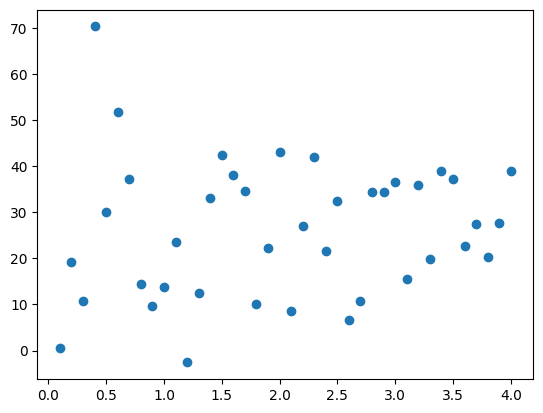

In [13]:
plt.scatter(a_list,mll_list)

In [14]:
b=0
b_list=[]
mll_list=[]
for i in range (40):
  b=b+0.1
  b_list.append(b)

  kernel1 = GPy.kern.StdPeriodic(input_dim=1,variance=1,lengthscale=1.782,active_dims=[0],period=13) \
          * GPy.kern.Matern52(input_dim=1,lengthscale=0.506,active_dims=[0])
  kernel2 = GPy.kern.StdPeriodic(input_dim=1,variance=b,lengthscale=1.579,active_dims=[1],period=2)
  kernel = kernel1 + kernel2


  optimizer = GPyOpt.methods.BayesianOptimization(f=knn_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
  optimizer.run_optimization(max_iter=20)
  X=(optimizer.X)
  m, v = optimizer.model.predict(X)
  mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
  mll_list.append(mll)
  print(f"log mll {mll}")

log mll [[29.70330254]]
log mll [[18.8053433]]
log mll [[44.96469456]]
log mll [[33.62521102]]
log mll [[41.90808254]]
log mll [[49.22608755]]
log mll [[37.13033153]]
log mll [[65.42184014]]
log mll [[40.51960378]]
log mll [[36.82903218]]
log mll [[9.14119739]]
log mll [[47.81279596]]
log mll [[30.69682842]]
log mll [[33.30007722]]
log mll [[27.04327124]]
log mll [[27.63826376]]
log mll [[40.5530903]]
log mll [[22.74365601]]
log mll [[44.08861923]]
log mll [[24.00483694]]
log mll [[18.87952584]]
log mll [[44.04758]]
log mll [[38.63981082]]
log mll [[22.30117325]]
log mll [[39.77125908]]
log mll [[16.17627712]]
log mll [[30.11313975]]
log mll [[48.91247133]]
log mll [[27.85039692]]
log mll [[14.41663391]]
log mll [[26.45327129]]
log mll [[39.80193221]]
log mll [[31.86658734]]
log mll [[29.83071357]]
log mll [[8.59146549]]
log mll [[23.41668887]]
log mll [[10.99614248]]
log mll [[57.16630782]]
log mll [[33.45866655]]
log mll [[54.82693257]]


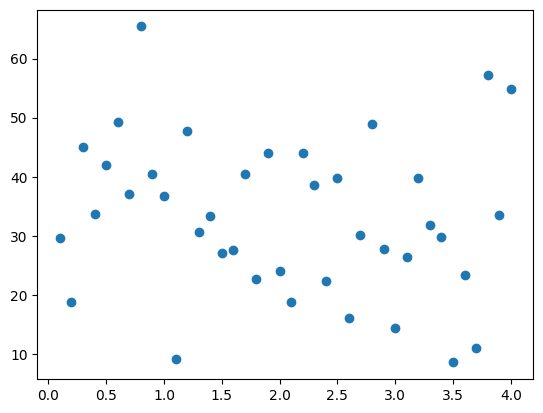

In [15]:
plt.scatter(b_list,mll_list)

In [20]:
kernel1 = GPy.kern.StdPeriodic(input_dim=1,variance=0.4,lengthscale=1.782,active_dims=[0],period=13) \
          * GPy.kern.Matern52(input_dim=1,lengthscale=0.506,active_dims=[0])
kernel2 = GPy.kern.StdPeriodic(input_dim=1,variance=0.7,lengthscale=1.579,active_dims=[1],period=2)
kernel = kernel1 + kernel2


optimizer = GPyOpt.methods.BayesianOptimization(f=knn_score, 
                                            domain=bounds,
                                            acquisition_type ='EI',
                                            initial_design_numdata = 5,
                                            model_type='GP',
                                            maximize=True,
                                            kernel=kernel
                                            )
optimizer.run_optimization(max_iter=20)
X=(optimizer.X)
m, v = optimizer.model.predict(X)
mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
      -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
print(mll)

[[28.17390303]]


{'covariance': [[<matplotlib.lines.Line2D at 0x7f259b889130>]]}

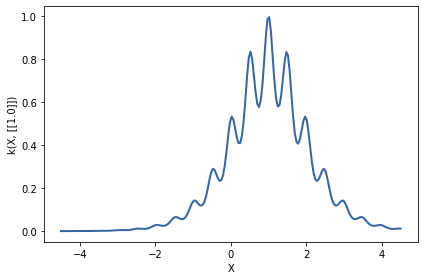

In [ ]:
kernel = GPy.kern.StdPeriodic(input_dim=1,period=0.5) * GPy.kern.Matern52(input_dim=1)
kernel.plot()

In [ ]:
l3 = np.linspace(0.1,3.0,101)
for i in range(30):
  l1_=random.choice(l1)
  l2_=random.choice(l2)
  l3_=random.choice(l3)
  kernel1 = GPy.kern.StdPeriodic(input_dim=1,lengthscale=l1_,active_dims=[0],period=13) \
          * GPy.kern.Matern52(input_dim=1,lengthscale=l2_,active_dims=[0])
  kernel2 = GPy.kern.StdPeriodic(input_dim=1,lengthscale=l3_,active_dims=[1],period=2)
  kernel = kernel1 + kernel2
  mll = BO(knn_score,kernel)
  print("l1 =", l1_, "l2 =", l2_, "l3 = ", l3_, "mll =", mll)

l1 = 0.129 l2 = 0.506 l3 =  1.115 mll = [[11.26468692]]
l1 = 0.6799999999999999 l2 = 2.4779999999999998 l3 =  1.782 mll = [[20.39480675]]
l1 = 1.173 l2 = 0.41899999999999993 l3 =  2.7969999999999997 mll = [[4.22959688]]
l1 = 1.782 l2 = 0.506 l3 =  1.579 mll = [[46.72121967]]
l1 = 1.695 l2 = 2.565 l3 =  0.593 mll = [[31.04956417]]
l1 = 1.521 l2 = 2.3329999999999997 l3 =  1.318 mll = [[25.44158669]]
l1 = 1.434 l2 = 2.6519999999999997 l3 =  1.608 mll = [[28.28499611]]
l1 = 2.594 l2 = 1.434 l3 =  2.217 mll = [[34.72167654]]
l1 = 1.811 l2 = 1.9849999999999999 l3 =  2.217 mll = [[36.29323343]]
l1 = 0.7959999999999999 l2 = 0.33199999999999996 l3 =  2.4779999999999998 mll = [[25.00109381]]
l1 = 1.26 l2 = 0.1 l3 =  1.55 mll = [[26.51873874]]
l1 = 1.521 l2 = 2.014 l3 =  1.956 mll = [[60.72237596]]
l1 = 2.6229999999999998 l2 = 2.6229999999999998 l3 =  3.0 mll = [[37.7647732]]
l1 = 0.564 l2 = 1.608 l3 =  1.666 mll = [[38.09984619]]
l1 = 2.507 l2 = 0.39 l3 =  2.768 mll = [[7.34025831]]
l1 = 0.76699